In [236]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [237]:
#System to solve :
#given q0 and p0 and model parameters k,m #  solve (dq/dt = p/m ; dp/dt = -kq)
# this script generates data points

In [238]:

class oscillator():
    def __init__(self, **kwargs):
        self.m = kwargs.get("m",1.)
        self.k = kwargs.get("k",1.)
        self.omega0 = (self.k/self.m)**0.5
    def compute_hamiltonian(self, trajectory):
        hamiltonian =  trajectory[0,:]**2*self.k +trajectory[1,:]**2/self.m
        hamiltonian *= 0.5
        return hamiltonian
    def compute_hamiltonian_derivative(self,t,x):
        f0 = x[1]/self.m
        f1 = -self.k*x[0]
        res = np.array([f0,f1])
        return res
    def simulate(self, x0, dt, n_steps, method = "RK45"):
        tspan = np.arange(n_steps)*dt
        sim_result = scipy.integrate.solve_ivp(fun = self.compute_hamiltonian_derivative, method= method, 
                                              y0=x0, t_span = [tspan.min(),tspan.max()], t_eval= tspan, vectorized=True)
        self.orbit = sim_result.y
        self.t = tspan
        self.exact_solution = sim_result.y*0
        A = x0[0]; B = x0[1]/(self.k)
        self.exact_solution[0,:] = A*np.cos(self.omega0*self.t)+B*np.sin(self.omega0*self.t)
        self.exact_solution[1,:] = (-A*np.sin(self.omega0*self.t)+B*np.cos(self.omega0*self.t))*self.omega0

In [246]:
kwargs = {}
kwargs["m"]=1
kwargs["k"] = 2
osc = oscillator(**kwargs) 

In [285]:
(2*np.pi/osc.omega0)/nstep

0.0004442882938158366

In [290]:
n_sims = 100
x0 = np.random.randn(n_sims*2)*10
x0=np.reshape(x0,(2,n_sims))
nstep =10000
dt = (2*np.pi/osc.omega0)/(nstep+1)
for i in tqdm(range(n_sims)):
    n_step = int(2*np.pi/osc.omega0/dt)+1
    osc.simulate(x0[:,i], dt=dt, n_steps=nstep, method = "RK45") #, method = "DOP853")
    integrated_energy = osc.compute_hamiltonian(osc.orbit)
    exact_energy =  osc.compute_hamiltonian(osc.exact_solution)
    if(i==0):
        trajectories = osc.exact_solution.T
        energies = integrated_energy*1
    else:
        trajectories = np.concatenate((trajectories,osc.orbit.T))
        energies = np.concatenate((energies,integrated_energy))

<IPython.core.display.Javascript object>


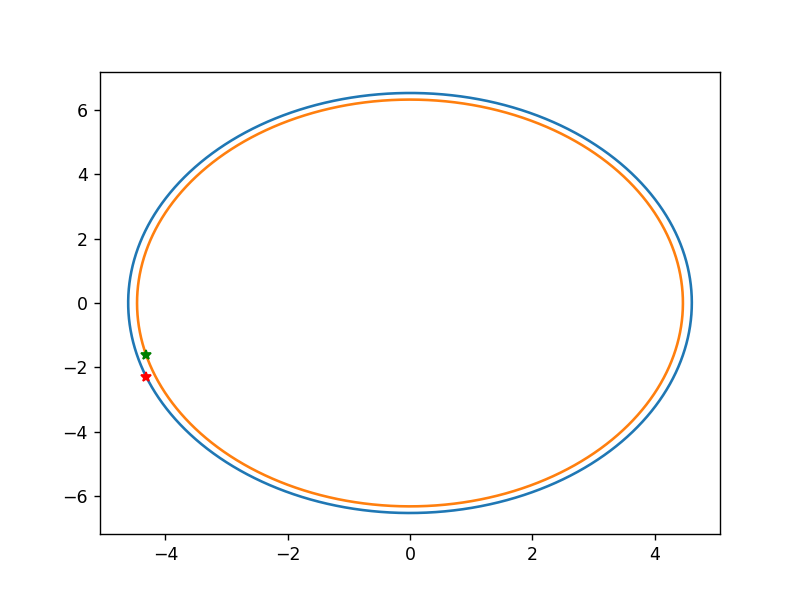

In [291]:
plt.figure()
plt.plot(osc.orbit[0,:], osc.orbit[1,:])
plt.plot(osc.exact_solution[0,:], osc.exact_solution[1,:])
plt.plot( osc.orbit[0,0], osc.orbit[1,0] , "r*")
plt.plot( osc.exact_solution[0,0], osc.exact_solution[1,0] , "g*")

In [292]:
from keras import Input, Model, regularizers
from keras.datasets import mnist
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

In [293]:
def square_activation(x):
    return K.pow(x,2)

get_custom_objects().update({'square_activation': Activation(square_activation)})

def power_four_activation(x):
    return K.pow(x,4)

get_custom_objects().update({'power_four_activation': Activation(power_four_activation)})

In [327]:
input_data = Input(shape=(2,))
new_layer = Dense(70, activation=square_activation)(input_data)
new_layer = Dense(40, activation='softplus')(new_layer)
new_layer = Dense(1, activation='softplus')(new_layer)
model = Model(input_data, new_layer)
#loss = model(input_data)
model.compile(optimizer='adam', loss='mean_absolute_error')


In [328]:
x_train = trajectories
y_train = energies[:,None]

In [329]:
history = model.fit(x_train, y_train,
                epochs=25,
                batch_size=1000,
                shuffle=True)

Epoch 1/25
1000/1000 [==============================] - 2s 2ms/step - loss: 6.0202
Epoch 2/25
1000/1000 [==============================] - 2s 2ms/step - loss: 0.4341
Epoch 3/25
1000/1000 [==============================] - 2s 2ms/step - loss: 0.4842
Epoch 4/25
1000/1000 [==============================] - 2s 2ms/step - loss: 0.5006
Epoch 5/25
1000/1000 [==============================] - 2s 2ms/step - loss: 0.4167
Epoch 6/25
1000/1000 [==============================] - 2s 2ms/step - loss: 0.4239
Epoch 7/25
1000/1000 [==============================] - 2s 2ms/step - loss: 0.4219
Epoch 8/25
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3992
Epoch 9/25
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3999
Epoch 10/25
1000/1000 [==============================] - 2s 2ms/step - loss: 0.4137
Epoch 11/25
1000/1000 [==============================] - 2s 2ms/step - loss: 0.4037
Epoch 12/25
1000/1000 [==============================] - 2s 2ms/step - loss: 0.4392
E

In [341]:
x_test = np.random.randn(100*2)*100+50
x_test =np.reshape(x_test,(100,2))
energy_test  = x_test[:,0]**2*osc.k*0.5 + x_test[:,1]**2/osc.m*0.5
y_pred = model.predict(x_test,batch_size=1000)

In [342]:
y_pred.shape

(100, 1)

<IPython.core.display.Javascript object>


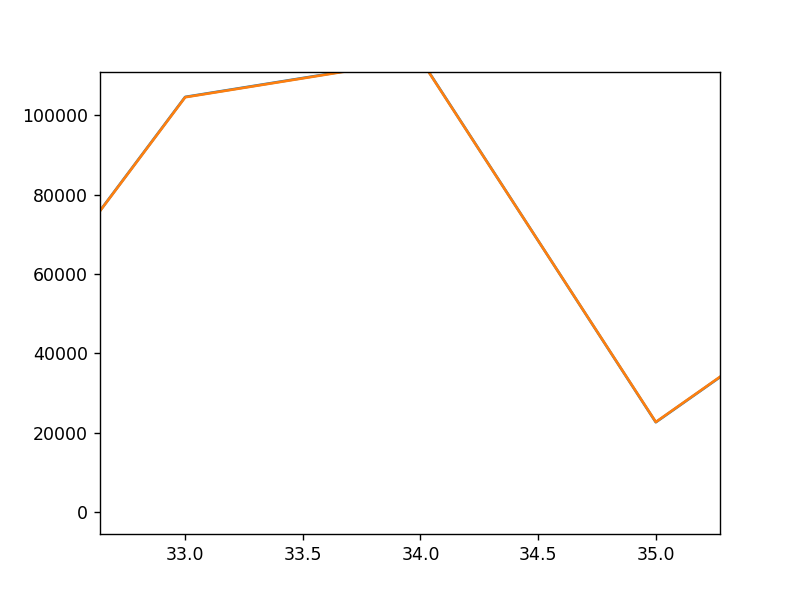

In [343]:
plt.figure()
plt.plot(y_pred[:,0])
plt.plot(energy_test[:])


<IPython.core.display.Javascript object>


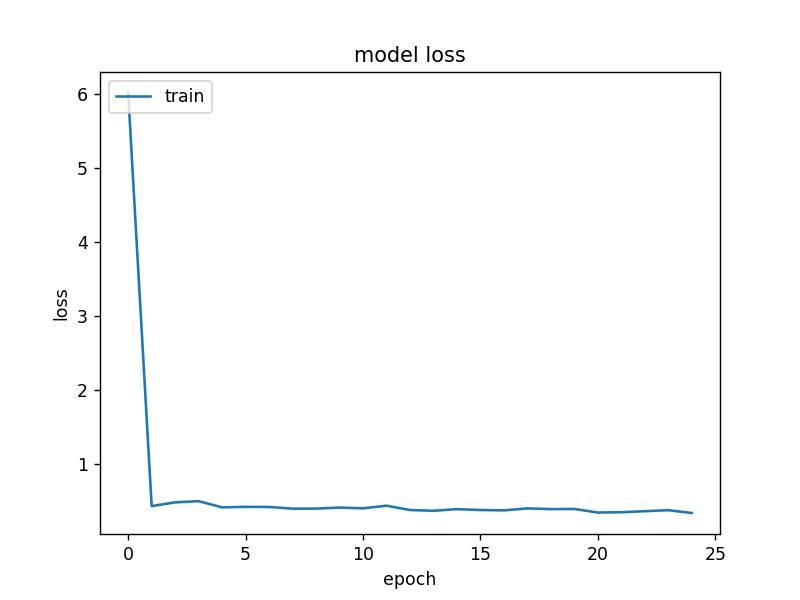

In [332]:
plt.figure()
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')